In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]

import copy

from astropy.io import fits

import numpy as np
import pickle
import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

import main

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

np.set_printoptions(threshold=np.nan)

# Example File for Comparison

In [15]:
hdul = fits.open(
#     '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/tf_z_3.100E+01_nstep_2049_logE_5.657E+00_xe_0.000E+00.fits'
      '/Users/hongwan/Dropbox (MIT)/Photon Deposition/idl_comparison/tf_z_3.000E+01_nstep_2016_logE_1.270E+01_xe_0.000E+00.fits'
)
data = hdul[1].data

idl_photonspectrum = data.field('photonspectrum')[0]
idl_lowengphot = data.field('lowengphot')[0]
idl_lowengelec = data.field('lowengelec')[0]
idl_energy = data.field('energy')[0]
idl_eleceng = data.field('eleceng')[0]
idl_redshift = data.field('redshift')[0]
idl_cmblosstable = data.field('cmblosstable')[0]

idl_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('energy')[0]))) * idl_energy
idl_elec_bin_width = np.diff(np.log(spectools.get_bin_bound(data.field('eleceng')[0]))) * idl_eleceng



Check that we understand the output of this file. The claim is that this file corresponds to the decay of a DM particle with mass given by $10^{5.657} \times 2 $, with decay lifetime given by $0.5 \times 10^{25}$ s. 

The total number of particles that should be present in the spectrum (which is the number of photons deposited in this timestep per baryon) is

$$ \frac{dN_\gamma}{dN_B \, d\log z} \times d \log z = \frac{dN_\gamma}{dN_\text{ann}} \frac{dN_\text{ann}}{dV \, dt} \frac{1}{n_B} \frac{dt}{d \log z} d \log z = \frac{dN_\gamma}{dN_\text{ann}} \frac{dE}{dV \, dt} \frac{1}{m_\chi n_B} \frac{d \log z}{H(z)} $$

Here, because of the mismatch between the injection photons, 2 photons of $4.53942 \times 10^5$ eV, and the bin in which it goes into, $4.2529 \times 10^5$ eV, the number of photons per annihilation is given by $dN_\gamma/dN_\text{ann} = 2 \times 4.53942/4.2529$. 

Note that we should expect a 1\% difference in results, because of the difference in cosmological parameters, particularly `rho_DM`. `phys.rho_DM = `1262.3925 eV/cm$^3$, but the value used in the IDL code is 1274.4140 eV/cm$^3$.

In [29]:
# m_chi = 10**5.657*2
m_chi = 5e12*2
rs = idl_redshift[0]

dE_dVdt = phys.inj_rate('decay', rs, tau = 0.5e25)

upp_most_bin = idl_energy[idl_energy <= m_chi/2][-1]
fac = 2*m_chi/2/upp_most_bin
print(fac)

dN_gamma_dN_B = fac*dE_dVdt/m_chi*0.001/phys.hubble(rs)/(phys.nB*rs**3)

print('Expected # of photons injected in first step of IDL file: ', dN_gamma_dN_B)

# Total number of particles in idl_photonspectrum[0,:], which is the initial injection
total_N_init_spec = np.dot(idl_photonspectrum[0,:], idl_bin_width)
print('# of photons injected in first step of IDL file: ', total_N_init_spec)

# Expected energy is dN_gamma_dN_B times the energy of the bin of injection.
print('Expected energy injected in first step of IDL file: ', dN_gamma_dN_B*upp_most_bin)
total_eng_init_spec = np.dot(idl_photonspectrum[0,:], idl_energy*idl_bin_width)
print('Energy injected in first step of IDL file: ', total_eng_init_spec)


2.0169593466213476
Expected # of photons injected in first step of IDL file:  1.0087174358817122e-15
# of photons injected in first step of IDL file:  1.0186440950398852e-15
Expected energy injected in first step of IDL file:  0.005001178816873214
Energy injected in first step of IDL file:  0.005050394777397165


In [33]:
utils.compare_arr([idl_energy, idl_photonspectrum[0,:]])

[[1.03931104e-04 0.00000000e+00]
 [1.12262993e-04 0.00000000e+00]
 [1.21262829e-04 0.00000000e+00]
 [1.30984159e-04 0.00000000e+00]
 [1.41484823e-04 0.00000000e+00]
 [1.52827298e-04 0.00000000e+00]
 [1.65079070e-04 0.00000000e+00]
 [1.78313035e-04 0.00000000e+00]
 [1.92607933e-04 0.00000000e+00]
 [2.08048817e-04 0.00000000e+00]
 [2.24727556e-04 0.00000000e+00]
 [2.42743387e-04 0.00000000e+00]
 [2.62203501e-04 0.00000000e+00]
 [2.83223683e-04 0.00000000e+00]
 [3.05928998e-04 0.00000000e+00]
 [3.30454541e-04 0.00000000e+00]
 [3.56946233e-04 0.00000000e+00]
 [3.85561696e-04 0.00000000e+00]
 [4.16471187e-04 0.00000000e+00]
 [4.49858613e-04 0.00000000e+00]
 [4.85922622e-04 0.00000000e+00]
 [5.24877791e-04 0.00000000e+00]
 [5.66955896e-04 0.00000000e+00]
 [6.12407295e-04 0.00000000e+00]
 [6.61502415e-04 0.00000000e+00]
 [7.14533365e-04 0.00000000e+00]
 [7.71815671e-04 0.00000000e+00]
 [8.33690151e-04 0.00000000e+00]
 [9.00524950e-04 0.00000000e+00]
 [9.72717723e-04 0.00000000e+00]
 [1.050698

0

# Transfer Function

In [30]:
highengphot_tflist_arr_raw = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/tfunclist_photspec_60eV_injE_complete_rs_30_xe_2pts.raw", "rb"))
lowengphot_tflist_arr_raw  = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/tfunclist_lowengphotspec_60eV_injE_complete_rs_30_xe_2pts.raw", "rb"))
lowengelec_tflist_arr_raw  = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/tfunclist_lowengelecspec_60eV_injE_complete_rs_30_xe_2pts.raw", "rb"))
CMB_engloss_raw = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tflists/CMB_engloss_60eV_injE_complete_rs_30_xe_2pts.raw", "rb"))

Let's just check that the first transfer function, corresponding to a delta function injection at the appropriate mass bin, agrees well with the subsequent steps of the IDL file.

Pick the `1` entry of the `tflist` for ionization, and the `-1` entry for the redshift of $1+z = 31$. The `114` entry in `in_eng` corresponds to $4.2529 \times 10^5$ eV. Remember that we need to multiply by 2*`dN_gamma_dN_B` (the number of photons per baryon in each step of $d \log z = 0.001$), since we are going to inject two steps of $d \log z = 0.001$ to be equivalent to propagation over two steps in the IDL file. 

Also 

Chosen rs is:  30.999998596096976
Chosen in_eng is:  4957958134729.496


/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


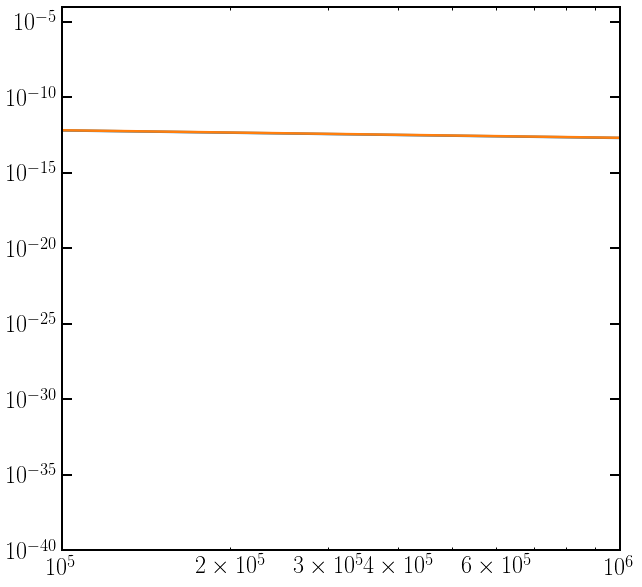

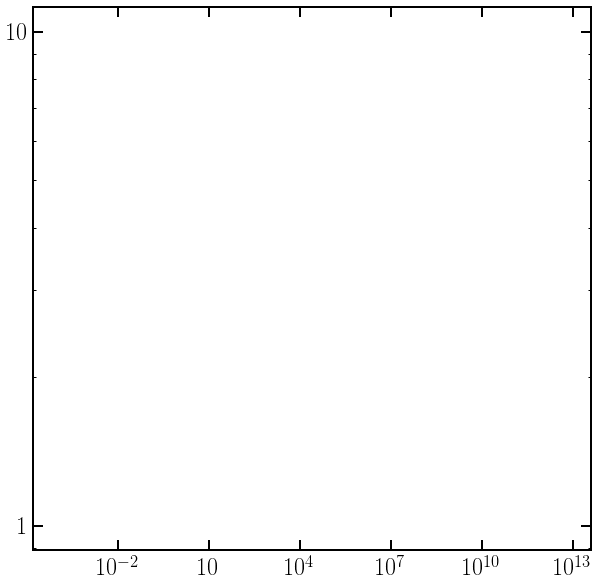

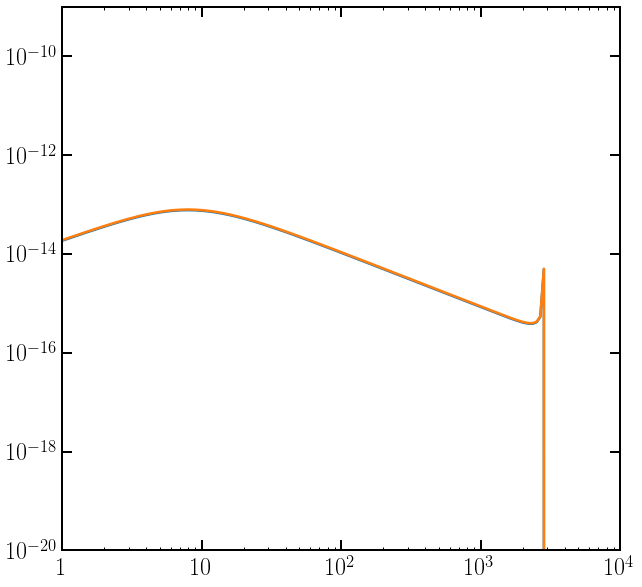

In [36]:
# Get the transfer functions. 
highengphot_tf = highengphot_tflist_arr_raw[0][-1]
lowengphot_tf  = lowengphot_tflist_arr_raw[1][-1]
lowengelec_tf  = lowengelec_tflist_arr_raw[0][-1]

# Choose index 114 for 10**5.657*2
# Choose index 325 for 5e12

ind = 325

print('Chosen rs is: ', highengphot_tf.rs[0])
print('Chosen in_eng is: ', highengphot_tf.in_eng[ind])

plt.figure()
ax = plt.gca()
ax.loglog()

plt.axis([1e5, 1e6, 1e-40, 1e-4])

highengphot_tf.plot(ax, ind=ind, indtype='ind', fac = dN_gamma_dN_B)
# This is the right comparison, because idl_photonspectrum[2,:] contains the delta function
# injection for the next step. 
plt.plot(idl_energy, (idl_photonspectrum[1,:] - idl_photonspectrum[0,:])*idl_bin_width)

plt.figure()
ax = plt.gca()
ax.loglog()

# plt.axis([1e-4, 1e4, 1e-40, 1e-4])

lowengphot_tf.plot(ax, ind=ind, indtype='ind', fac = dN_gamma_dN_B)
plt.plot(idl_energy, (idl_lowengphot[1,:])*idl_bin_width)

plt.figure()
ax = plt.gca()
ax.loglog()

plt.axis([1, 1e4, 1e-20, 1e-9])

lowengelec_tf.plot(ax, ind=ind, indtype='ind', fac = dN_gamma_dN_B)
plt.plot(idl_eleceng, (idl_lowengelec[1,:])*idl_elec_bin_width)


In [7]:
utils.compare_arr([idl_energy, idl_photonspectrum[1,:] - idl_photonspectrum[0,:], highengphot_tf.eng, highengphot_tf[114].dNdE*dN_gamma_dN_B])


[[1.03931104e-04 1.79030521e-05 1.03931104e-04 1.77374845e-05]
 [1.12262993e-04 1.93250507e-05 1.12262993e-04 1.91463325e-05]
 [1.21262829e-04 2.08588390e-05 1.21262829e-04 2.06659356e-05]
 [1.30984159e-04 2.25130298e-05 1.30984159e-04 2.23048284e-05]
 [1.41484823e-04 2.42968399e-05 1.41484823e-04 2.40721428e-05]
 [1.52827298e-04 2.62201684e-05 1.52827298e-04 2.59776856e-05]
 [1.65079070e-04 2.82936144e-05 1.65079070e-04 2.80319576e-05]
 [1.78313035e-04 3.05285612e-05 1.78313035e-04 3.02462345e-05]
 [1.92607933e-04 3.29371906e-05 1.92607933e-04 3.26325956e-05]
 [2.08048817e-04 3.55324482e-05 2.08048817e-04 3.52038524e-05]
 [2.24727556e-04 3.83283223e-05 2.24727556e-04 3.79738712e-05]
 [2.42743387e-04 4.13395828e-05 2.42743387e-04 4.09572837e-05]
 [2.62203501e-04 4.45821242e-05 2.62203501e-04 4.41698420e-05]
 [2.83223683e-04 4.80727504e-05 2.83223683e-04 4.76282437e-05]
 [3.05928998e-04 5.18295092e-05 3.05928998e-04 5.13502113e-05]
 [3.30454541e-04 5.58714273e-05 3.30454541e-04 5.535475

0

In [8]:
user = '/Users/hongwan/Dropbox (MIT)/Photon Deposition/'
highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp, CMB_engloss_arr = main.load_trans_funcs(user)#+'/Dropbox (MIT)/Photon Deposition/')

Loading transfer functions...
Loaded high energy photons...
Low energy photons...
Low energy electrons...
CMB losses.

Padding tflists with zeros...
high energy photons...
low energy photons...
low energy electrons...

CMB losses.

Generating TransferFuncInterp objects for each tflist...
Done.



In [9]:
highengphot_tf_interp.xe

array([4.53978687e-05, 2.74578156e-04])

In [40]:
inj_type = 'decay'
inj_particle = 'photon'

# mDM = 10**5.657*2
mDM = 5e12*2
tau = 0.5e25
    
if inj_particle is "electron":
    rest_energy = phys.me
elif inj_particle is "photon":
    rest_energy = 0
else:
    raise TypeError('Specify either electron or photon final state')

eng = highengphot_tf_interp.eng
indx = np.where(eng < mDM/2 - rest_energy)[-1][-1]
fac = (mDM/2 - rest_energy)/eng[indx]
spec_arr = np.zeros_like(eng)
spec_arr[indx] = 2*fac
tmp_spec = Spectrum(
    eng, spec_arr,
    spec_type = 'N'
)
    
tmp_spec.rs = 30

phot_spec_init =   tmp_spec
elec_spec_init = 0*tmp_spec
    
def rate_func_N(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, tau=tau)/mDM
def rate_func_eng(rs):
    return phys.inj_rate(inj_type, rs, mDM=mDM, tau=tau)



In [41]:
coarsen_factor = 1
end_rs = 4

a1 = main.evolve(
    elec_spec_init, phot_spec_init,
    rate_func_N, rate_func_eng, end_rs,
    highengphot_tf_interp, lowengphot_tf_interp, lowengelec_tf_interp,
    #ics_thomson_ref_tf, ics_rel_ref_tf, engloss_ref_tf
    coarsen_factor=coarsen_factor, std_soln=True
)

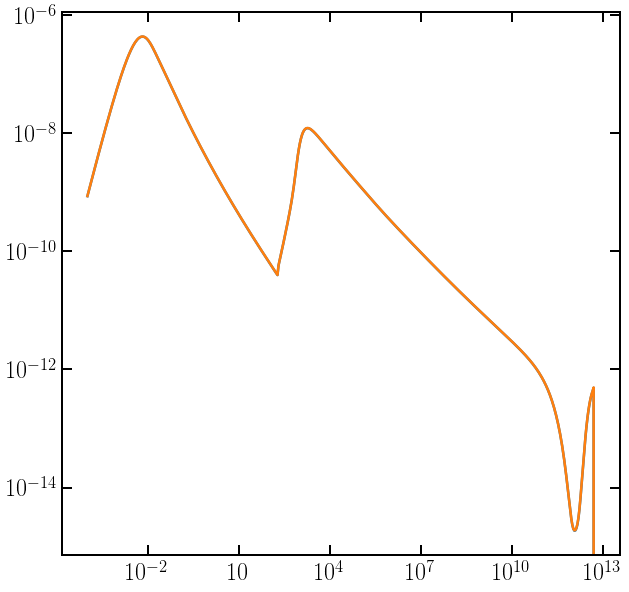

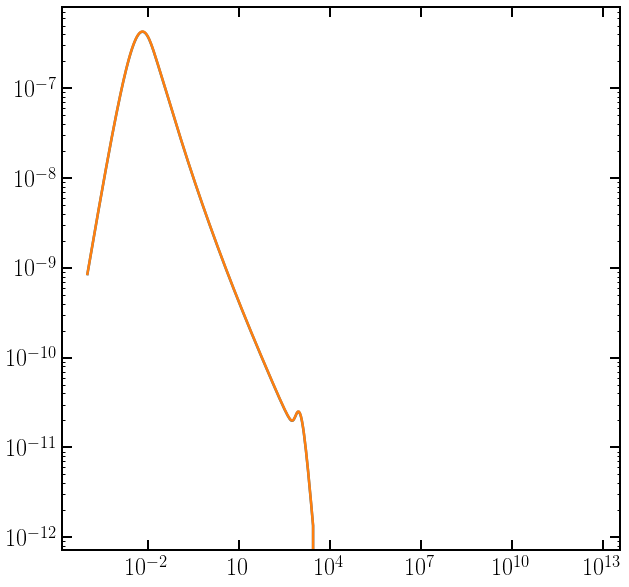

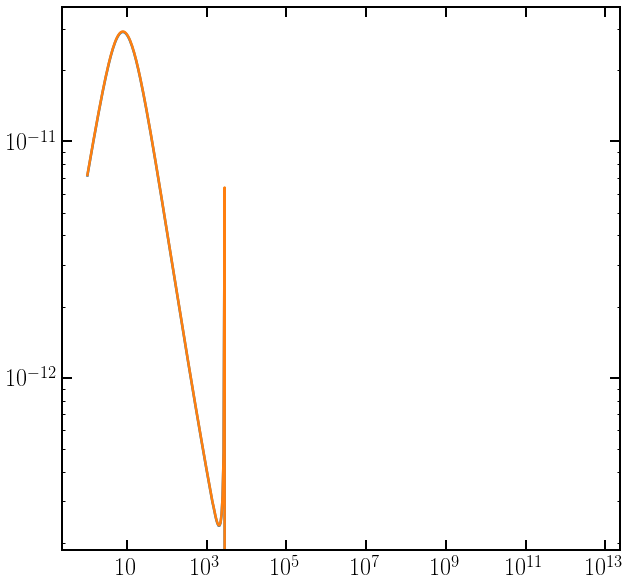

In [42]:
plt.figure()
ax = plt.gca()
ax.loglog()

# plt.axis([1e5, 1e6, 1e-10, 1e-7])

a1[2].plot(ax, ind=1300, indtype='ind')
plt.plot(idl_energy, (idl_photonspectrum[1300,:] - 0*idl_photonspectrum[0,:])*idl_bin_width)

plt.figure()
ax = plt.gca()
ax.loglog()

a1[3].plot(ax, ind=1300, indtype='ind')
plt.plot(idl_energy, (idl_lowengphot[1300,:])*idl_bin_width)

plt.figure()
ax = plt.gca()
ax.loglog()

a1[4].plot(ax, ind=1300, indtype='ind', fac=1)
plt.plot(idl_eleceng, (idl_lowengelec[1301,:])*idl_elec_bin_width)

In [43]:
a1[2][1300].N/(idl_photonspectrum[1300,:]*idl_bin_width)

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.99560363, 0.99560243, 0.99560041, 0.99559732, 0.9955959 ,
       0.99559426, 0.99558897, 0.99558667, 0.99558467, 0.99558003,
       0.99557592, 0.99557352, 0.99556876, 0.99556324, 0.99555934,
       0.99555561, 0.99554725, 0.99554357, 0.99553854, 0.99553003,
       0.99552256, 0.99551811, 0.99550983, 0.99549934, 0.99549333,
       0.99548581, 0.99547078, 0.99546457, 0.99545754, 0.99544079,
       0.99543099, 0.99542408, 0.99540818, 0.99539283, 0.99538604,
       0.99537302, 0.99535184, 0.99534522, 0.99533746, 0.99531438,
       0.99530551, 0.99530175, 0.99528352, 0.99527247, 0.99527329,
       0.99526645, 0.99525713, 0.99526629, 0.99527631, 0.99527894,
       0.99530172, 0.99533161, 0.99536148, 0.99540552, 0.99545847,
       0.99552524, 0.99560494, 0.995682  , 0.99577206, 0.99590628,
       0.99599125, 0.99607312, 0.99622466, 0.99631527, 0.99635627,
       0.99646099, 0.9965389 , 0.99652199, 0.99654336, 0.99661986,
       0.99656217, 0.99651501, 0.99658041, 0.99654612, 0.99648